In [1]:
import time
startTime = time.time()
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
import seaborn as sn
import seaborn as sns
import pylab as plt

#gaussian mixture clustering
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

#correspondence analysis
import mca

#datavis thing
import dtale

In [2]:
%%time
d1 = pd.read_csv("diabetic_data.csv", delim_whitespace = False)
d2 = pd.read_csv("IDs_mapping.csv", delim_whitespace = False)
df1 = pd.DataFrame(data = d1)

df_idmapping = d2

df = d1

Wall time: 403 ms


In [3]:
%%time
#drop columns that aren't relevant or we aren't going to use
#we can use number_diagnoses in place of diag_1, diag_2, diag_3
df.drop(['encounter_id','patient_nbr','diag_1','diag_2','diag_3'], axis=1, inplace=True)

#for now drop the medication columns to shrink the dataset
df.drop(['metformin','repaglinide','nateglinide','chlorpropamide',
         'glimepiride','acetohexamide','glipizide','glyburide',
         'tolbutamide','pioglitazone','rosiglitazone','acarbose',
         'miglitol','troglitazone','tolazamide','examide','citoglipton',
         'insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
         'metformin-rosiglitazone','metformin-pioglitazone'], axis=1, inplace=True)

df.drop(['weight','medical_specialty','max_glu_serum','A1Cresult'], axis=1, inplace=True)

df.dropna(subset=['payer_code','race'], axis=0, inplace=True)

#target variable
target = {"readmitted": {"NO": 0, "<30": 1, ">30": 2}}
df.replace(target,inplace=True)

#cleaning
df = df.replace('?', np.nan)
df = df.replace('None', np.nan)

df['age_num'] = df['age'].astype(str).str[1]
df.drop(['age'], axis=1, inplace=True)

#onehot encoding for variables with 2 categoriesd
#this dataset to be used with K-MODES
df['IsMale'] = df.gender=='Male' 
df.IsMale = df.IsMale.astype(np.int)
df.drop(['gender'], axis=1, inplace=True)

df['med_change'] = df.change=='Ch'
df.med_change = df.med_change.astype(np.int)
df.drop(['change'], axis=1, inplace=True)

df['med_diabetes'] = df.diabetesMed=='Yes'
df.med_diabetes = df.med_diabetes.astype(np.int)
df.drop(['diabetesMed'], axis=1, inplace=True)


#create new dataset to be used with distance based clustering algorithms
df_imputed = df

#onehot encoding for variables with more than 2 categories
tmp_df = pd.get_dummies(df_imputed.race,prefix='race')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['race'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.payer_code,prefix='payer')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['payer_code'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_type_id,prefix='admission_type')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_type_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.discharge_disposition_id,prefix='discharge')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['discharge_disposition_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_source_id,prefix='admission_source')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_source_id'], axis=1, inplace=True)

df_imputed.dtypes

Wall time: 847 ms


time_in_hospital         int64
num_lab_procedures       int64
num_procedures           int64
num_medications          int64
number_outpatient        int64
number_emergency         int64
number_inpatient         int64
number_diagnoses         int64
readmitted               int64
age_num                 object
IsMale                   int32
med_change               int32
med_diabetes             int32
race_AfricanAmerican     uint8
race_Asian               uint8
race_Caucasian           uint8
race_Hispanic            uint8
race_Other               uint8
payer_BC                 uint8
payer_CH                 uint8
payer_CM                 uint8
payer_CP                 uint8
payer_DM                 uint8
payer_FR                 uint8
payer_HM                 uint8
payer_MC                 uint8
payer_MD                 uint8
payer_MP                 uint8
payer_OG                 uint8
payer_OT                 uint8
                         ...  
discharge_14             uint8
discharg

In [4]:
#convert objects to categories
df_cat = df
df_cat['race'] = df_cat['race'].astype('category')
df_cat['payer_code'] = df_cat['payer_code'].astype('category')
df_cat['age_num'] = df_cat['age_num'].astype('category')

df_cat = df_cat.dropna(axis = 'rows')

df_cat.dtypes

race                        category
admission_type_id              int64
discharge_disposition_id       int64
admission_source_id            int64
time_in_hospital               int64
payer_code                  category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
number_diagnoses               int64
readmitted                     int64
age_num                     category
IsMale                         int32
med_change                     int32
med_diabetes                   int32
dtype: object

In [5]:
df_cat2 = df_cat.copy() #use to prevent drops from affecting the original df
df_cat2.drop(['readmitted'], axis=1, inplace=True)
df_cat2.dtypes

race                        category
admission_type_id              int64
discharge_disposition_id       int64
admission_source_id            int64
time_in_hospital               int64
payer_code                  category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
number_diagnoses               int64
age_num                     category
IsMale                         int32
med_change                     int32
med_diabetes                   int32
dtype: object

In [6]:
%%time
#numeric only data for mca
df_num_only = df_imputed.select_dtypes(['int32', 'uint8', 'int64'])

df_num_only.dropna()
df_num_only.dtypes

df_num_only2 = df_num_only.copy()
df_num_only2.drop(['readmitted'], axis=1, inplace=True)

num_target = df_num_only['readmitted'].copy()


Wall time: 136 ms


## Business Understanding
[10 points] Describe the purpose of the data set you selected (i.e., why was this data collected in the ﬁrst place?). How will you measure the effectiveness of a good 
algorithm? Why does your chosen validation method make sense for this speciﬁc dataset and the stakeholders needs? 



## Data Understanding
[10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data ﬁle. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems? 

[10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.  

## Modeling and Evaluation
Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

### Multiple Correspondence Analysis with KMeans Clustering
(use MCA to reduce dimensionality, then cluster the results)

Wall time: 7.7 s


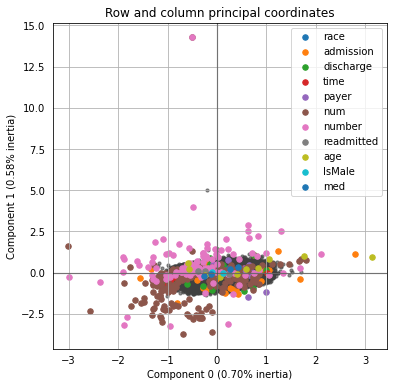

In [7]:
%%time
#mca test #9
import prince #this library is outdated, needs to be run on pandas 0.24.2 #pip install pandas==0.24.2

data = df_cat

#2 components
mca = prince.MCA(
n_components = 2,  #range from 2;4 components
n_iter = 20)

mca = mca.fit(data)

m1_i = mca.total_inertia_
m1_exi = mca.explained_inertia_
m1_eigen = mca.eigenvalues_

ax = mca.plot_coordinates(
    X = data, 
    x_component = 0,
    y_component = 1,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

mca1 = mca.transform(df_cat) #use this to cluster

Wall time: 11 s


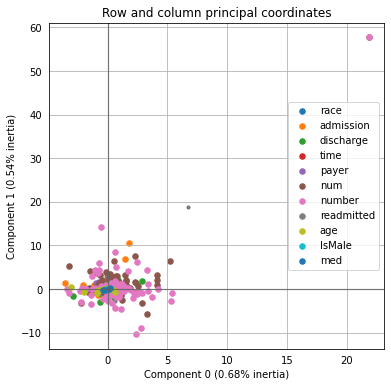

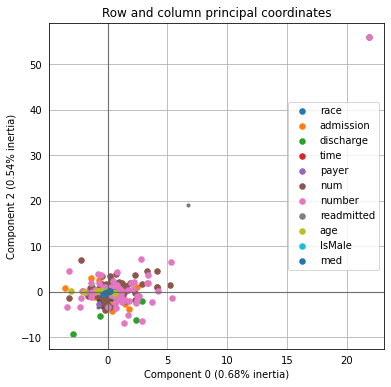

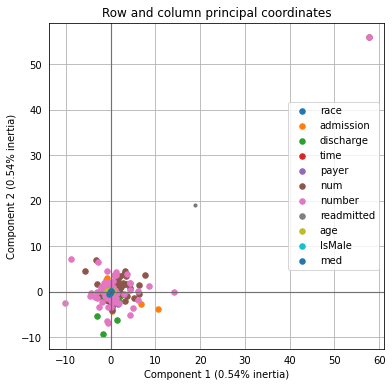

In [8]:
%%time
#3 components
mca = prince.MCA(
n_components = 3,  #range from 2;4 components
n_iter = 3)

mca = mca.fit(data)

m2_i = mca.total_inertia_
m2_exi = mca.explained_inertia_
m2_eigen = mca.eigenvalues_

mca2 = mca.transform(df_cat) #use this to cluster

ax1 = mca.plot_coordinates(
    X = data, 
    x_component = 0,
    y_component = 1,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

ax2 = mca.plot_coordinates(
    X = data, 
    x_component = 0,
    y_component = 2,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

ax3 = mca.plot_coordinates(
    X = data, 
    x_component = 1,
    y_component = 2,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

Wall time: 18.8 s


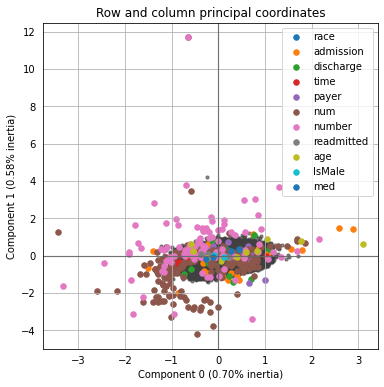

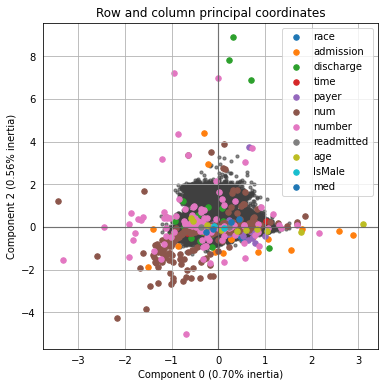

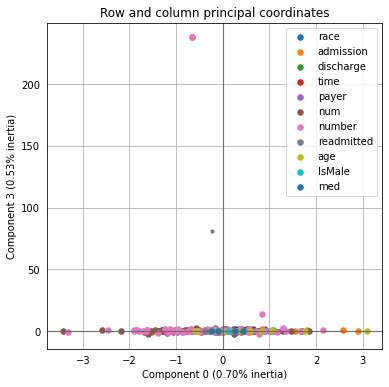

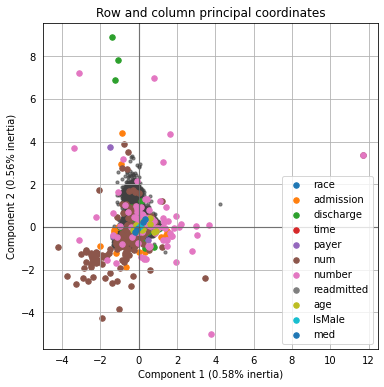

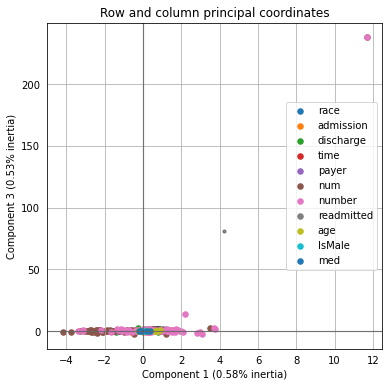

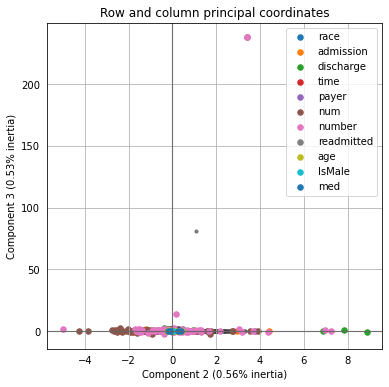

In [9]:
%%time
#4 components
mca = prince.MCA(
n_components = 4,  #range from 2;4 components
n_iter = 5)

mca = mca.fit(data)

m3_i = mca.total_inertia_
m3_exi = mca.explained_inertia_
m3_eigen = mca.eigenvalues_

mca3 = mca.transform(df_cat) #use this to cluster

ax1 = mca.plot_coordinates(
    X = data, 
    x_component = 0,
    y_component = 1,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

ax2 = mca.plot_coordinates(
    X = data, 
    x_component = 0,
    y_component = 2,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

ax3 = mca.plot_coordinates(
    X = data, 
    x_component = 0,
    y_component = 3,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

ax4 = mca.plot_coordinates(
    X = data, 
    x_component = 1,
    y_component = 2,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

ax5 = mca.plot_coordinates(
    X = data, 
    x_component = 1,
    y_component = 3,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

ax6 = mca.plot_coordinates(
    X = data, 
    x_component = 2,
    y_component = 3,
    show_row_points = True, 
    show_row_labels = False, 
    legend_n_cols = 1, 
    show_column_labels = False)

In [10]:
from IPython.display import HTML, display
import tabulate

table = [["# of Components", "Total Model Inertia", "Explainable Inertia", "Eigenvalues"], 
        ["2", m1_i, m1_exi, m1_eigen], 
        ["3", m2_i, m2_exi, m2_eigen], 
        ["4", m3_i, m3_exi, m3_eigen]]
display(HTML(tabulate.tabulate(table, tablefmt = 'html')))

# of Components,Total Model Inertia,Explainable Inertia,Eigenvalues
2,21.444444444444443,"[0.006963365351078505, 0.005792752786261016]","[0.14932550141757236, 0.12422236530537512]"
3,21.444444444444443,"[0.006775830790130347, 0.00541692899023829, 0.005356995605311451]","[0.14530392694390631, 0.11616303279066556, 0.11487779464723444]"
4,21.444444444444443,"[0.006960031184012633, 0.0057737379469989724, 0.0055502068471951745, 0.005323733976264498]","[0.14925400205715977, 0.12381460264120017, 0.11902110238985207, 0.11416451749100533]"


Component quantity doesn't seem to have much effect on results; inertia is very low, indicating low seperability of this dataset, at least approached from this angle. 

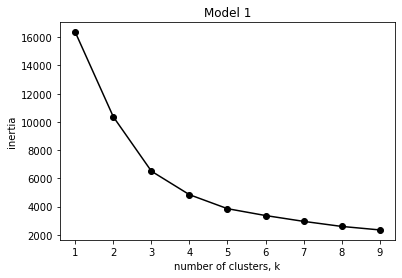

In [11]:
# cluster on mca results
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(mca1.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('Model 1')
plt.xticks(ks)
plt.show()


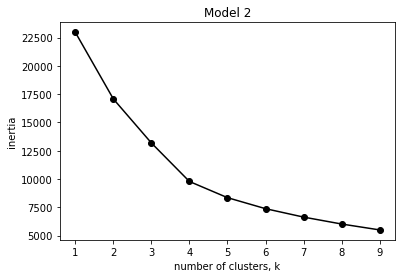

In [12]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(mca2.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('Model 2')
plt.xticks(ks)
plt.show()

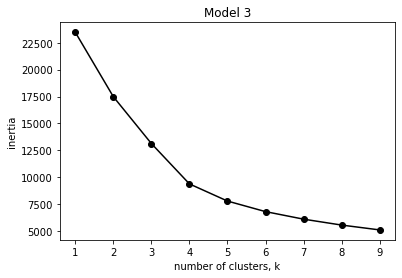

In [13]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(mca3.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('Model 3')
plt.xticks(ks)
plt.show()

3 or 4 clusters for all models

KNN on MCA model

D:\Anaconda\lib\site-packages\sklearn\manifold\_spectral_embedding.py:212: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.



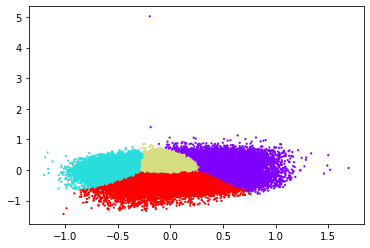

Wall time: 1min 14s


In [14]:
%%time
#spectral mca1
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph

X = (np.array(mca1).reshape(-1, 2))
nclust = 4
Xknn = kneighbors_graph(X, 10) 

spc = SpectralClustering(n_clusters=nclust, affinity = 'precomputed')
labels = spc.fit_predict(Xknn) 

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

In [140]:
newfeature

array([0, 2, 1, ..., 0, 0, 0])

In [138]:
%%time
y = pd.DataFrame(mca1.iloc[:,1])
y = y.to_numpy()
y.reshape(1, -1)

y2 = y.flatten()
y2.shape

newfeature = labels.flatten()

silhouette_e = metrics.silhouette_score(y,labels, metric='euclidean')
silhouette_c = metrics.silhouette_score(y, labels, metric='cosine')

seuclid.append(silhouette_e)
scosine.append(silhouette_c)

print("Homogeneity: ", metrics.homogeneity_score(y2, newfeature))
print("Completeness: ", metrics.completeness_score(y2, newfeature))
print("V-measure: ", metrics.v_measure_score(y2, newfeature))
print("Adjusted Rand Index: ", metrics.adjusted_rand_score(y2, newfeature))
print("Adjusted Mutual Information: ", metrics.adjusted_mutual_info_score(y2, newfeature, average_method='arithmetic'))
print("Silhouette Coefficient - Euclidean: ", silhouette_e)
print("Silhouette Coefficient - Cosine: ", silhouette_c)

Homogeneity:  0.09968607990626925
Completeness:  1.0
V-measure:  0.18129915751005213
Adjusted Rand Index:  8.895407548615579e-09
Adjusted Mutual Information:  1.246257715438421e-05
Silhouette Coefficient - Euclidean:  0.17242884810642314
Silhouette Coefficient - Cosine:  0.1733734583242655
Wall time: 2min


Interpretation is ... ? [squashed google chrome]

completeness of 1 is unusual? a byproduct of the large amount of overlap between "clusters"

D:\Anaconda\lib\site-packages\sklearn\manifold\_spectral_embedding.py:212: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.



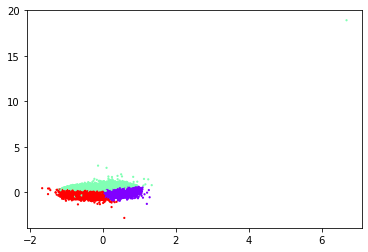

Wall time: 2min 23s


In [141]:
%%time
#spectral mca1 2
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph

X = (np.array(mca2).reshape(-1, 3))
nclust = 3
Xknn = kneighbors_graph(X, 10) 

spc = SpectralClustering(n_clusters=nclust, affinity = 'precomputed')
labels = spc.fit_predict(Xknn) 

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

In [142]:
%%time
y = pd.DataFrame(mca2.iloc[:,1])
y = y.to_numpy()
y.reshape(1, -1)

y2 = y.flatten()
y2.shape

newfeature = labels.flatten()

silhouette_e = metrics.silhouette_score(y,labels, metric='euclidean')
silhouette_c = metrics.silhouette_score(y, labels, metric='cosine')

seuclid.append(silhouette_e)
scosine.append(silhouette_c)

print("Homogeneity: ", metrics.homogeneity_score(y2, newfeature))
print("Completeness: ", metrics.completeness_score(y2, newfeature))
print("V-measure: ", metrics.v_measure_score(y2, newfeature))
print("Adjusted Rand Index: ", metrics.adjusted_rand_score(y2, newfeature))
print("Adjusted Mutual Information: ", metrics.adjusted_mutual_info_score(y2, newfeature, average_method='arithmetic'))
print("Silhouette Coefficient - Euclidean: ", silhouette_e)
print("Silhouette Coefficient - Cosine: ", silhouette_c)

Homogeneity:  0.09968895471810653
Completeness:  0.9999999999999998
V-measure:  0.18130391196601717
Adjusted Rand Index:  8.896256798183622e-09
Adjusted Mutual Information:  1.246300996672352e-05
Silhouette Coefficient - Euclidean:  0.14428677793857464
Silhouette Coefficient - Cosine:  0.15334994899557994
Wall time: 2min


Unusually high completeness aside, metrics for clustering on MCA are quite low. (more elaboration later)

## Principal Component Analysis with Decision Tree Classifier
(oops this isn't actually clustering)

In [82]:
# %%time

#PCA clustering
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier



X = df_num_only2 #dataset without target variable
y = num_target

# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=3)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.53911


In [91]:
%%time

from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score

seuclid = []
scosine = []

y = num_target.sample(frac = 0.3)
newfeature = preds[:,0]

silhouette_e = metrics.silhouette_score(df_num_only2, num_target, metric='euclidean')
silhouette_c = metrics.silhouette_score(df_num_only2, num_target, metric='cosine')

seuclid.append(silhouette_e)
scosine.append(silhouette_c)

print("Homogeneity: ", metrics.homogeneity_score(y, newfeature))
print("Completeness: ", metrics.completeness_score(y, newfeature))
print("V-measure: ", metrics.v_measure_score(y, newfeature))
print("Adjusted Rand Index: ", metrics.adjusted_rand_score(y, newfeature))
print("Adjusted Mutual Information: ", metrics.adjusted_mutual_info_score(y, newfeature, average_method='arithmetic'))
print("Silhouette Coefficient - Euclidean: ", silhouette_e)
print("Silhouette Coefficient - Cosine: ", silhouette_c)

#running a single k for now

Homogeneity:  6.492804389106336e-05
Completeness:  5.924177260192402e-05
V-measure:  6.195470880637646e-05
Adjusted Rand Index:  -0.00027852542702950513
Adjusted Mutual Information:  -3.7356573095430296e-05
Silhouette Coefficient - Euclidean:  -0.011869404204372144
Silhouette Coefficient - Cosine:  -0.05053463093137546
Wall time: 5min 7s


adapted jenna's metrics here, confirms that PCA method kinda sucks


In [21]:
%%time
from matplotlib import cm 
  
# generating correlation data 
dfc = df_num_only.corr() 
dfc.index = range(0, len(dfc)) 
dfc.rename(columns = dict(zip(dfc.columns, dfc.index)), inplace = True) 
dfc = dfc.astype(object) 
  
''' Generating coordinates with  
corresponding correlation values '''
for i in range(0, len(dfc)): 
    for j in range(0, len(dfc)): 
        if i != j: 
            dfc.iloc[i, j] = (i, j, dfc.iloc[i, j]) 
        else : 
            dfc.iloc[i, j] = (i, j, 0) 
  
dfc_list = [] 
  
# flattening dataframe values 
for sub_list in dfc.values: 
    dfc_list.extend(sub_list) 
  
# converting list of tuples into trivariate dataframe 
plot_dfc = pd.DataFrame(dfc_list) 
  
fig = plt.figure() 
ax = Axes3D(fig) 
  
# plotting 3D trisurface plot 
ax.plot_trisurf(plot_dfc[0], plot_dfc[1], plot_dfc[2],  
                    cmap = cm.jet, linewidth = 0.2) 
  
plt.show() 
#this is a cool visualization, may have use elsewhere?

NameError: name 'Axes3D' is not defined

<Figure size 432x288 with 0 Axes>

## Cluster Analysis / Association Rule Mining / Collaborative Filtering

## Deployment
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

• How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? 

• How would your deploy your model for interested parties?  

• What other data should be collected? 

• How often would the model need to be updated, etc.? 

## Exceptional Work